# 1d2v-GEMPIC-Vlasov-Maxwell-Solver

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fembase as fem
import picbase as pic
from bsplines import Bspline
from scipy.integrate import fixed_quad
from scipy import integrate
from copy import deepcopy
import scipy as sc
import time

## Simulation parameters

In [2]:
# wavenumber of perturbations
k = 1.25

# boundaries and length of domain
a_boundary = 0
b_boundary = 2*np.pi/k
Lx = b_boundary - a_boundary


# number of elements and element boundaries
Nel = 32
el_b = np.linspace(a_boundary, b_boundary, Nel + 1)

# element size
dx = (b_boundary - a_boundary)/Nel

# degree of Lagrange basis functions in V0
degree = 1


# degree and width of B-spline smoothing kernel
p = 3
dS = dx/8
Swidth = (p + 1)*dS


# number of particles for simulation
Np = np.int(1e5)

# time step and simulation time
dt = 0.05
Tend = 0.051
Nt = np.int(Tend/dt)


# paramters for inital conditions
alpha = 0
beta = 10e-4
sigma_1 = 0.02/np.sqrt(2)
sigma_2 = np.sqrt(12)*sigma_1


# physical constants
eps0 = 1
q = -1
m = 1
c = 1

In [3]:
# time integrators for Hamiltonian splitting
def integrator_HE(b, v_x, v_y, dt):
    
    bnew = b - dt*np.dot(Grad, e)
    v_xnew = v_x + dt*q/m*S.transpose().dot(ex)
    v_ynew = v_y + dt*q/m*Q0.transpose().dot(e)
    
    return bnew, v_xnew, v_ynew




def integrator_HB(e, b, dt):
    
    enew = e + dt*c**2*np.dot(mass_0_inv, np.dot(np.transpose(Grad), np.dot(mass_1, b)))
    
    return enew



def integrator_Hy(e, v_x, v_y, x_p, dt):
    
    enew = e - dt/eps0*q/m*np.dot(mass_0_inv, Q0.dot(W.dot(v_y)))
    v_xnew = v_x + q/m*B.dot(v_y)
    
    return enew, v_xnew




def integrator_Hx(ex, b, x_p, v_x, v_y, dt, kernel_supp):
    
    x_pnew = x_p + dt*v_x
    #print('end x_p = ', x_pnew)
    # new particle positions (without periodic boundary conditions)
    
    Ny = len(knots)
    # number of spline knots (of smoothing kernel)
    
    Np = len(x_p)
    # particle number
    
    
    #I_ip = sc.sparse.csr_matrix((len(ex), Np)) 
    
    
    row_S = np.array([])
    col_S = np.array([])
    dat_S = np.array([])
    
    t_vec  = np.zeros((Ny, Np))
    t_all = Lx/np.abs(v_x)
    
     
    
    for ii in range(len(ex)):
        
        
        y_vec = (knots + x_vec[ii])%Lx
        #print('y_vec = ', y_vec)
        
        for iy in range(len(y_vec)):
            t_vec[iy] = ((y_vec[iy] - x_p)/v_x)%t_all
            
        
        #print('t_vec = ', t_vec)
        # assemble t_vec which gives the times when the particles reach the nodes defining the smoothing kernel
        
        ind_t_min = np.argmin(t_vec, axis = 0)
        #print('ind_t_min = ', ind_t_min)
        
        print('Treating position: ', ii)
        
        for pp in range(Np):
            t_lower = 0.
            t_upper = 0.
            
            row_S = np.append(row_S, ii)
            col_S = np.append(col_S, pp)
            dat_S = np.append(dat_S, 0.)
            
            for iy in range(len(y_vec)):
                
                #if v_x[pp] > 0:
                 #   ind_now = (ind_t_min[pp] + iy)%len(y_vec)
                #else:
                 #   ind_now = (ind_t_min[pp] - iy)%len(y_vec)
                    
                ind_now = (int_t_min[pp] + np.sign(v_x[pp])*iy)%len(y_vec)
                 
                #print('ind_now = ', ind_now)
                
                t_now = t_vec[ind_now, pp]
                #print('t_now = ', t_now)
                
                poly_ind = ind_now - int(np.heaviside(v_x[pp], 1))
                #print('poly_ind = ', poly_ind)
                
                integrand = lambda s : poly_list[poly_ind]((x_p[pp] + s*v_x[pp])%Lx - y_vec[poly_ind])
                
                
                
                if t_now > dt:
                    if np.abs(x_pnew[pp] - x_vec[ii]) < kernel_supp/2:
                        #print('Case 0')
                        t_upper = dt 
                        
                        #print('t_lower/upper = ', t_lower, t_upper)
                        
                
                        int_val = fixed_quad(integrand, t_lower, t_upper, n = np.ceil((p + 1)/2))[0]
                        #print('int_val = ', int_val)
                        
                        #I_ip[ii, pp] += int_val
                        #print('I_ip = ', I_ip[ii, pp])
                        
                        dat_S[-1] += int_val     
                        break
                    
                        
                    elif np.abs(x_pnew[pp]%Lx - x_vec[ii]) < kernel_supp/2 and t_now < Lx/(2*np.abs(v_x[pp])):
                        #print('Case 1')
                        t_upper = dt 
                        
                        #print('t_lower/upper = ', t_lower, t_upper)
                
                        int_val = fixed_quad(integrand, t_lower, t_upper, n = np.ceil((p + 1)/2))[0]
                        #print('int_val = ', int_val)
                        
                        #I_ip[ii, pp] += int_val
                        #print('I_ip = ', I_ip[ii, pp])
                        
                        dat_S[-1] += int_val
                        break
                    
                    else:
                        #print('Case 2')
                        break
                        
                else:
                    if (ind_now == 0 and v_x[pp] > 0) or (ind_now == (p + 1) and v_x[pp] < 0):
                        #print('Case 3')
                        t_lower = t_now
                        #print('t_lower/upper = ', t_lower, t_upper)
                        continue
                    
                    else:
                        #print('Case 4')
                        t_upper = t_now
                 
               
                #print('t_lower/upper = ', t_lower, t_upper)
                
                int_val = fixed_quad(integrand, t_lower, t_upper, n = np.ceil((p + 1)/2))[0]
                #print('int_val = ', int_val)
            
                    
                dat_S[-1] += int_val
                      
                t_lower = t_now  
    
    
    I_ip = sc.sparse.csr_matrix((dat_S, (row_S, col_S)), shape = (len(ex), Np))
    #print(I_ip.toarray())
    
                                
                                
    row_B = np.array([])
    col_B = np.array([])
    dat_B = np.array([])
    
    
    t_vec  = np.zeros((Nel, Np))
    t_all = Lx/np.abs(v_x)
    
    for iy in range(Nel):
        t_vec[iy] = ((el_b[iy] - x_p)/v_x)%t_all
        
    
    #print('t_vec = ', t_vec)
    # assemble t_vec which gives the times when the particles reach the element boundaries
    
    
    ind_t_min = np.argmin(t_vec, axis = 0)
    #print('ind_t_min = ', ind_t_min)
    # identify the element boundary which is reached first
    
        
    for pp in range(Np):
        t_lower = 0.
        t_upper = 0.

        for iy in range(Nel):

            #if v_x[pp] > 0:
             #   ind_now = (ind_t_min[pp] + iy)
            #else:
             #   ind_now = (ind_t_min[pp] - iy)
                
            ind_now = int_t_min[pp] + np.sign(v_x[pp])*iy

            #print('ind_now = ', ind_now)

            t_now = t_vec[ind_now%Nel, pp]
            #print('t_now = ', t_now)

            element = (ind_now - int(np.heaviside(v_x[pp], 1)))%Nel
            #print('element = ', element)



            if t_now > dt:
                #print('Case 1')
                
                t_upper = dt
                #print('t_lower/upper = ', t_lower, t_upper)
                
                for il in range(degree):
                    integrand = lambda s : shapefun.chi[il](2*((x_p[pp] + s*v_x[pp])%Lx - el_b[element])/(el_b[element + 1] - el_b[element]) - 1)

                    int_val = fixed_quad(integrand, t_lower, t_upper, n = np.ceil((degree + 1)/2))[0]
                    #print('int_val = ', int_val)
                    
                    row_B = np.append(row_B, element*degree + il)
                    col_B = np.append(col_B, pp)
                    dat_B = np.append(dat_B, int_val)
                
                break

            else:
                #print('Case 2')
                
                t_upper = t_now
                #print('t_lower/upper = ', t_lower, t_upper)
                
                for il in range(degree):
                    integrand = lambda s : shapefun.chi[il](2*((x_p[pp] + s*v_x[pp])%Lx - el_b[element])/(el_b[element + 1] - el_b[element]) - 1)

                    int_val = fixed_quad(integrand, t_lower, t_upper, n = np.ceil((degree + 1)/2))[0]
                    #print('int_val = ', int_val)
                    
                    row_B = np.append(row_B, element*degree + il)
                    col_B = np.append(col_B, pp)
                    dat_B = np.append(dat_B, int_val)
                
                t_lower = t_now
                    
    B_ip = sc.sparse.csr_matrix((dat_B, (row_B, col_B)), shape = (Nel*degree, Np)) 
    
    
    
    
    # compute new quantities
    x_pnew = x_pnew%Lx
    
    exnew = ex - 1/eps0*q/m*I_ip.dot(W).dot(v_x)
    
    temp = B_ip.transpose().dot(b)
    IB = sc.sparse.csr_matrix((temp, (np.arange(Np), np.arange(Np))), shape = (Np, Np))
    
    v_ynew = v_y - q/m*IB.dot(W).dot(v_x)
    

    return exnew, x_pnew, v_ynew  
    #return 0.

0.041666666666666664
0.5
0.9583333333333333
0.9999999999999999


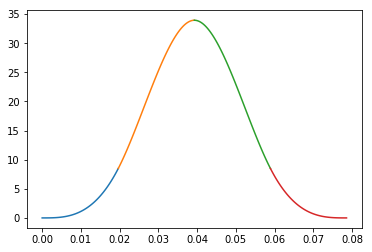

In [4]:
# unit test for the spline parts
poly_list, knots, kernel = pic.spline_parts(p, dS)

x_plot = np.linspace(0, dS, 100)
intgr = 0

for i in range(p + 1):
    plt.plot(x_plot + i*dS, poly_list[i](x_plot))
    intgr += fixed_quad(poly_list[i], 0, dS, n = np.ceil((p + 1)/2))[0]
    print(intgr)

In [5]:
# unit test for integrator_Hx (S - matrix)
#Lx = 2
#ex = np.array([1])

#x_p = np.array([0.1])
#print('start x_p = ', x_p)

#v_x = np.array([1])
#print('v_x = ', v_x)

#dt = 2*np.pi
#x_vec = np.array([Lx/2])

#integrator_Hx(ex, b, x_p, v_x, particles[:, 2], dt, Swidth)

In [6]:
# unit test for integrator_Hx (B - matrix)
#Lx = 2
#Nel = 4
#el_b = np.linspace(0, Lx, Nel + 1)
#dx = el_b[1] - el_b[0]
#degree = 3
#shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))


#x_p = np.array([0.75, 1.25])
#x_p = np.random.rand(1)*Lx
#print('start x_p = ', x_p)




#v_x = np.array([-1, 1])
#v_x = np.random.rand(1)
#print('v_x = ', v_x)


#dt = 0.5

#B_ip = integrator_Hx(np.array([1]), x_p, v_x, 1, dt, (p + 1)*dS)[1]

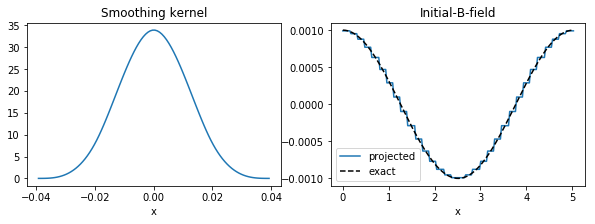

In [7]:
# create and plot the smoothing kernel        
poly_list, knots, kernel = pic.spline_parts(p, dS)
    
supp = np.linspace(-(p + 1)/2*dS, (p + 1)/2*dS, 100)
y = kernel(supp)

f1 = plt.figure()
f1.set_figheight(3)
f1.set_figwidth(10)

plt.subplot(121)
plt.plot(supp, y)
plt.xlabel('x')
plt.title('Smoothing kernel')


# create Lagrange shape functions in V1 and V0 and compute global matrices M0 and M1
shapefun = fem.LagrangeShape(np.linspace(-1, 1, degree + 1))
Nbase_0, mass_0 = fem.lag_assemb(el_b, shapefun.mass0, shapefun.stiff0, bcs = 2)[1:3]
Nbase_0_tilde, mass_0_tilde = fem.lag_assemb(el_b, shapefun.mass0, shapefun.stiff0, bcs = 1)[1:3]
Nbase_1, mass_1 = fem.lag_assemb(el_b, shapefun.mass1, shapefun.stiff1, basis = 2, bcs = 2)[1:3]

mass_0_inv = np.linalg.inv(mass_0)



# initialize B-field, compute initial coefficients by projection on the basis and check result
B_0 = lambda x: beta*np.cos(k*x)

x_vec, b = fem.lag_proj(shapefun.s, el_b, B_0)
fun = fem.lag_fun(b, shapefun.chi, el_b, basis = 2)[2]
x_plot = np.linspace(a_boundary, b_boundary, 200)

plt.subplot(122)
plt.plot(x_plot, fun(x_plot), label = 'projected')
plt.plot(x_plot, B_0(x_plot), 'k--', label = 'exact')
plt.xlabel('x')
plt.title('Initial-B-field')
plt.legend()

time for S assembly: 0.04804730415344238


Text(0.5,1,'Initial Ex-field')

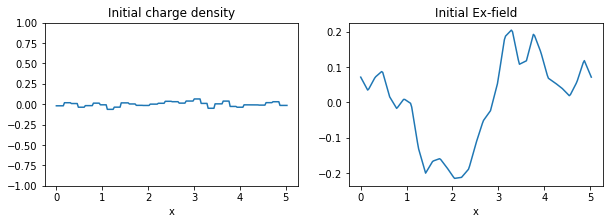

In [8]:
# assemble gradient matrix
grad1 = np.ones(Nbase_0)
grad2 = -np.ones(Nbase_0 - 1)
Grad = np.diag(grad1) + np.diag(grad2, -1)
Grad = np.append(Grad, [np.zeros(Nbase_0)], axis = 0)
Grad[-1, -1] = -1

# assemble gradient matrix_tilde
grad1 = np.ones(Nbase_1 - 1)
grad2 = -np.ones(Nbase_1)
Grad_tilde = np.diag(grad2) + np.diag(grad1, +1)
Grad_tilde[-1, :] = 1


# initialize distribution function and define sampling distribution for initial markers
#alpha = 0.1
n0 = lambda x: 1 + alpha*np.cos(k*x)

f0 = lambda x,vx,vy: n0(x)*1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2)) 
g0 = lambda x,vx,vy: 1/Lx*1/(2*np.pi*sigma_1*sigma_2)*np.exp(-1/2*(vx**2/sigma_1**2 + vy**2/sigma_2**2)) 



# create particles and compute weights
particles = np.zeros((Np, 4))

particles[:, 0] = np.random.rand(Np)*Lx
particles[:, 1] = np.random.randn(Np)*sigma_1 
particles[:, 2] = np.random.randn(Np)*sigma_2 

particles[:, 3] = 1/Np*f0(particles[:, 0], particles[:, 1], particles[:, 2])/g0(particles[:, 0],particles[:, 1], particles[:, 2])




# assembly of intitial S and global knot vector
timea = time.time()

S, x_vec = pic.assemb_S(particles[:, 0], kernel, Swidth, el_b, shapefun.s)

timeb = time.time()
print('time for S assembly: ' + str(timeb - timea))
temp = S.dot(particles[:, 3])


# the computation of rho at the boundaries is complicated, because we loose mass at the boundaries due to the finite size of the smoothing kernel
rho = np.zeros(Nbase_1)
# charge density of multiple species

for ie in range(Nel):
    jac = 2/(el_b[ie + 1] - el_b[ie])

    for il in range(degree):
        i = ie*degree + il
        
        rho[i] = (x_vec[i + 1] - x_vec[i])*jac + q*jac/2*(x_vec[i + 1] - x_vec[i])*(temp[(i + 1)%Nbase_1] + temp[i])
        # trapezoidal rule for integral
        

        
        
# compute E-fields
rho_bc = deepcopy(rho)
rho_bc[-1] = 0
ex = np.linalg.solve(Grad_tilde, rho_bc)
e = np.zeros(Nbase_0)

f2 = plt.figure()
f2.set_figheight(3)
f2.set_figwidth(10)

dens = fem.lag_fun(rho, shapefun.chi, el_b, basis = 2)[2]
elec = fem.lag_fun(ex, shapefun.eta, el_b, basis = 1, bcs = 1)[2]

plt.subplot(121)
plt.plot(x_plot,dens(x_plot))
plt.xlabel('x')
plt.ylim((-1,1))
plt.title('Initial charge density')

plt.subplot(122)
plt.plot(x_plot,elec(x_plot))
plt.xlabel('x')
plt.title('Initial Ex-field')

time for Q assembly: 0.08382129669189453


(-1, 1)

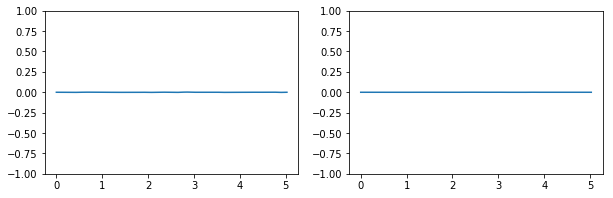

In [9]:
# weight matrix
W_row = np.arange(Np)
W = sc.sparse.csr_matrix((particles[:, 3], (W_row, W_row)), shape = (Np, Np))

timea = time.time()

Q0 = pic.assemb_Q(particles[:, 0], shapefun, el_b)
timeb = time.time()

print('time for Q assembly: ' + str(timeb - timea))

h_vec = W.dot(particles[:, 2])
j_vec = q*Q0.dot(h_vec)

hx_vec = W.dot(particles[:, 1])
jx_vec = q*S.dot(hx_vec)


j_cof = np.dot(mass_0_inv, j_vec)
jx_cof = jx_vec

j_fun = fem.lag_fun(j_cof, shapefun.eta, el_b, bcs = 2)[2]
jx_fun = fem.lag_fun(jx_cof, shapefun.eta, el_b, bcs = 1)[2]

f3 = plt.figure()
f3.set_figheight(3)
f3.set_figwidth(10)

plt.subplot(121)
plt.plot(x_plot, j_fun(x_plot))
plt.ylim((-1,1))
plt.title('initial j')

plt.subplot(122)
plt.plot(x_plot, jx_fun(x_plot))
plt.ylim((-1,1))
plt.title('initial jx')

In [10]:
# time integration
time_now = 0.

while time_now < Tend:
    time_now += dt
    print(time_now)
    
    # Lie-Trotter-splitting
    
    # E-integrator
    b, particles[:, 1], particles[:, 2] = integrator_HE(b, particles[:, 1], particles[:, 2], dt)
    print('E-integrator finished')
    
    # B-integrator
    e = integrator_HB(e, b, dt)
    print('B-integrator finished')
    
    # X-integrator
    ex, particles[:, 0], particles[:, 2] = integrator_Hx(ex, b, particles[:, 0], particles[:, 1], particles[:, 2], dt, Swidth)
    print('X-integrator finished')
    
    Q0 = pic.assemb_Q(particles[:, 0], shapefun, el_b)
    Q1 = pic.assemb_Q(particles[:, 0], shapefun, el_b, basis=1)
    S = pic.assemb_S(particles[:, 0], kernel, Swidth, el_b, shapefun.s)[0]
    
    # Y-integrator
    temp = Q1.transpose().dot(b)
    B = sc.sparse.csr_matrix((temp, (np.arange(Np), np.arange(Np))), shape = (Np, Np))
    
    
    e, particles[:, 1] = integrator_Hy(e, particles[:, 1], particles[:, 2], particles[:, 0], dt)
    print('Y-integrator finished')    

0.05
E-integrator finished
B-integrator finished
Treating position:  0
Treating position:  1
Treating position:  2
Treating position:  3
Treating position:  4
Treating position:  5


KeyboardInterrupt: 

In [11]:
timea = time.time()
test = 1 + 2
timeb = time.time()
print(timeb - timea)

0.0001533031463623047


In [ ]:
Nbase_0

In [ ]:
Nbase_1